--------------------------------------------------------------
CS210 PROJECT - SCRAPING NETFLIX HISTORY by Murat Darı
--------------------------------------------------------------

"🎬 Unlocking the mysteries of my Netflix journey! 📊 Discovering top genres, binge-watching habits, series on repeat, and the preferred midnight show. 🌙🍿 What captivates my screen time? Let's find out! 🧐 #DataScience #NetflixInsights"

---See the hidden cells for webscraping, else continue with analysis---


In [72]:
#Imports
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import pandas as pd
import time

In [ ]:
# login info -> dummy password
netflixEmail = "mynetflixemail"
netflixPassw = "X" # after scraping will change this variable with "x" to not to give my netflix password to Onur Varol :)

driver = webdriver.Chrome()

driver.get("https://www.netflix.com/tr-en/login")

In [ ]:
#logging in
time.sleep(10)  # wait for page to load

# automate login
email_input = driver.find_element(By.ID, 'id_userLoginId')
password_input = driver.find_element(By.ID, 'id_password')

email_input.send_keys(netflixEmail)
password_input.send_keys(netflixPassw)
password_input.submit()

In [ ]:
#profile selector
def select_profile(driver, profile_name):
    try:
        # Wait for the profile selector to appear
        profile_selector = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '/html/body/div[1]/div/div/div[1]/div[1]/div[2]/div/div/ul')))
        
        # Find and click on the desired profile
        profile = profile_selector.find_element(By.XPATH, f"li[div/a/span[text()='{profile_name}']]")
        profile.click()

        print(f"Selected profile: {profile_name}")
    except TimeoutException:
        print(f"Failed to select profile: {profile_name}")


In [ ]:
#select profile and go to history page

# Select the desired profile
select_profile(driver, "Murat")

time.sleep(7) # 7 sec sleep to login, connection may be slow
viewActivityPage = "https://www.netflix.com/viewingactivity?u=0&p="

# activity page for a specific profile of mine
driver.get(viewActivityPage + "Murat")

# wait for loading
history_list = WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.XPATH, '/html/body/div[1]/div/div/div/div[2]/div/div/ul')))


--------------------------------------------------------------
OPTION 1 -> SCRAPING ALL DATA (OPTION 2 PREFERRED IF IN HURRY)


In [ ]:
# exporting history data
history_items = []
prev_item_count = 0

while True:
    # get data
    for item in history_list.find_elements(By.XPATH, 'li'):
        history_items.append({"History Item": item.text})

    # find the "Show More" button and click
    try:
        show_more_button = driver.find_element(By.XPATH, '//button[text()="Show More"]')
        show_more_button.click()

        time.sleep(2)  # wait after clicking show more button
        
        # get lenght to compare with older length, as show more button does not disappear when there is nothing more to show
        current_item_count = len(history_list.find_elements(By.XPATH, 'li'))

        # if counts are same with older cycle, then there is nothing to show more, we can break
        # else counts aren't equal, update count
        if current_item_count == prev_item_count:
            break

        prev_item_count = current_item_count

    except:
        # just for the cases if page is not loaded well
        break

# df with pandas
df = pd.DataFrame(history_items)

# raw data to csv file to upload github
df.to_csv("netflix_history.csv", index=False)

# print df (partially as it is too big, just checking)
print(df)

driver.quit()

--------------------------------------------------------------
OPTION 2 - SCRAPING THEN CLICKING "DOWNLOAD ALL HISTORY BUTTON"

In [ ]:
download_button_xpath = "/html/body/div[1]/div/div/div/div[2]/div/div/div[2]/div[2]/a[2]"
download_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, download_button_xpath)))
download_button.click()
driver.quit()

Data to pandas df and data cleaning
---

----
Now we will work with our DataFrame created with pandas library. This section includes the analysing steps.

In [287]:

csv_file_path = 'NetflixViewingHistory.csv'
netflix_data = pd.read_csv(csv_file_path)


# extract Series, Season (if 'Sezon' is present), and Episode
split_columns = netflix_data['Title'].str.extract(r'^(.*?)(?:\s*:\s*(\d+)\.\s*Sezon)?(?:\s*:\s*(.*))?$')
split_columns.columns = ['Series', 'Season', 'Episode']
split_columns['Season'].fillna('1', inplace=True)
split_columns['Episode'].fillna('Movie/Mini Series', inplace=True)

# extracted Series, Season, and Episode in the DataFrame
netflix_data_cleaned = netflix_data.copy()
netflix_data_cleaned = pd.concat([netflix_data_cleaned, split_columns], axis=1)

# A movie is identified if both 'Season' and 'Episode' are 'Unknown'
netflix_data_cleaned['Episode'] = netflix_data_cleaned.apply(
    lambda row: row['Title'] if row['Season'] == 'Unknown' and row['Episode'] == 'Unknown' else row['Episode'],
    axis=1
)

# 'Date' to datetime
netflix_data_cleaned['Date'] = pd.to_datetime(netflix_data_cleaned['Date'], format='%d.%m.%Y')
netflix_data_cleaned['DayOfWeek'] = netflix_data_cleaned['Date'].dt.day_name()
netflix_data_cleaned['Month'] = netflix_data_cleaned['Date'].dt.month_name()


# adjusted data
netflix_data_cleaned.tail(15)  

,Title,Date,Series,Season,Episode,DayOfWeek,Month
2060,Delidolu,2018-11-04,Delidolu,1,Movie/Mini Series,Sunday,November
2061,American Vandal: 1. Sezon: Somut Gerçekler: Va...,2018-10-16,American Vandal,1,Somut Gerçekler: Vandalizm ve Müstehcenlik,Tuesday,October
2062,The End of the F***ing World: 1. Sezon: 1. Bölüm,2018-10-16,The End of the F***ing World,1,1. Bölüm,Tuesday,October
2063,Riverdale: 1. Sezon: No. 13: Öbür Dünya,2018-10-16,Riverdale,1,No. 13: Öbür Dünya,Tuesday,October
2064,Élite: 1. Sezon: Assilah,2018-10-14,Élite,1,Assilah,Sunday,October
2065,Élite: 1. Sezon: Her Şey Altüst Olur,2018-10-14,Élite,1,Her Şey Altüst Olur,Sunday,October
2066,Élite: 1. Sezon: Her Şey Yoluna Girecek,2018-10-14,Élite,1,Her Şey Yoluna Girecek,Sunday,October
2067,Élite: 1. Sezon: Herkes Yalan Söyler,2018-10-12,Élite,1,Herkes Yalan Söyler,Friday,October
2068,Élite: 1. Sezon: Aşk Bir Uyuşturucudur,2018-10-11,Élite,1,Aşk Bir Uyuşturucudur,Thursday,October
2069,Élite: 1. Sezon: Cumartesi Gecesi,2018-10-11,Élite,1,Cumartesi Gecesi,Thursday,October


---
Checking with df.head if we correctly imported our dataframe and split it

In [253]:
df = netflix_data_cleaned
df.head(20)

,Title,Date,Series,Season,Episode,DayOfWeek,Month
0,The Crown: 6. Sezon: Will Çılgınlığı,2024-01-12,The Crown,6,Will Çılgınlığı,Friday,January
1,The Crown: 6. Sezon: Sonuçlar,2024-01-12,The Crown,6,Sonuçlar,Friday,January
2,The Crown: 6. Sezon: Dis-Moi Oui,2024-01-11,The Crown,6,Dis-Moi Oui,Thursday,January
3,The Crown: 6. Sezon: İki Fotoğraf,2024-01-11,The Crown,6,İki Fotoğraf,Thursday,January
4,The Crown: 6. Sezon: Persona Non Grata,2024-01-10,The Crown,6,Persona Non Grata,Wednesday,January
5,The Crown: 5. Sezon: Kullanım Dışı,2024-01-10,The Crown,5,Kullanım Dışı,Wednesday,January
6,The Crown: 5. Sezon: 31. Çift,2024-01-10,The Crown,5,31. Çift,Wednesday,January
7,Beni Kandıramazsın: Mini Dizi: 1. Bölüm,2024-01-07,Beni Kandıramazsın,1,Mini Dizi: 1. Bölüm,Sunday,January
8,Don't Look Up,2024-01-07,Don't Look Up,1,Movie/Mini Series,Sunday,January
9,I Care a Lot,2024-01-07,I Care a Lot,1,Movie/Mini Series,Sunday,January


---
DATA ANALYSIS AND VISUALIZATION
---

---
---
Exploratory Data Analysis (EDA) Preparation:
---


In [288]:
import matplotlib.pyplot as plt
import seaborn as sns

In [289]:
print("Dataframe Info")
print(df.info())

print("\nDataframe Describe")
print(df.describe())


Dataframe Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Title      2068 non-null   object        
 1   Date       2075 non-null   datetime64[ns]
 2   Series     2068 non-null   object        
 3   Season     2075 non-null   int64         
 4   Episode    2075 non-null   object        
 5   DayOfWeek  2075 non-null   object        
 6   Month      2075 non-null   object        
 7   Cluster    2075 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(5)
memory usage: 121.7+ KB
None

Dataframe Describe
            Season      Cluster
count  2075.000000  2075.000000
mean      1.165783     3.618795
std       0.731233     3.004454
min       1.000000     0.000000
25%       1.000000     1.000000
50%       1.000000     3.000000
75%       1.000000     5.000000
max      18.000000    11.000000


---
EDA Step 1: Frequency Analysis
---
Most frequently watched series

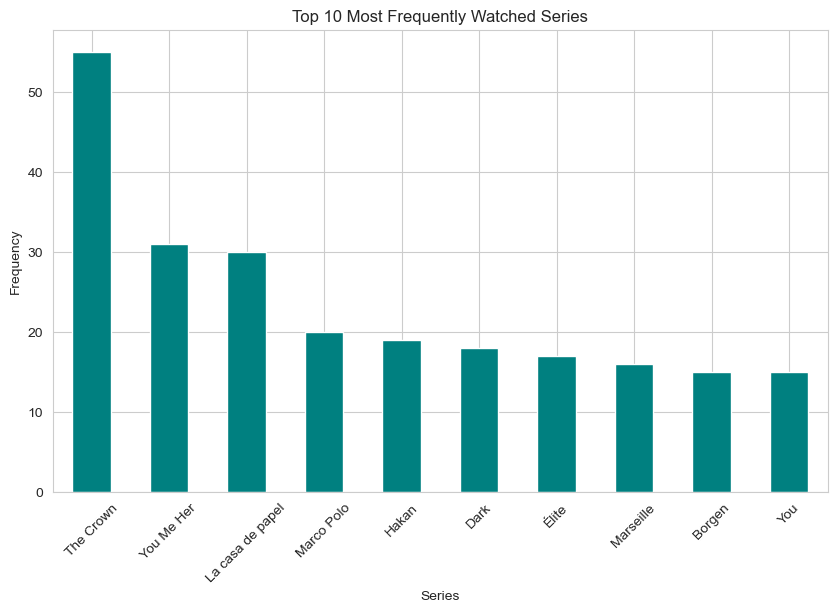

In [290]:
sns.set_style("whitegrid")


series_counts = netflix_data_cleaned['Series'].value_counts().head(10)
plt.figure(figsize=(10, 6))
series_counts.plot(kind='bar', color='teal')
plt.title('Top 10 Most Frequently Watched Series')
plt.xlabel('Series')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

---
EDA Step 2: Viewing Patterns Over Time
---
Viewing patterns by day of the week

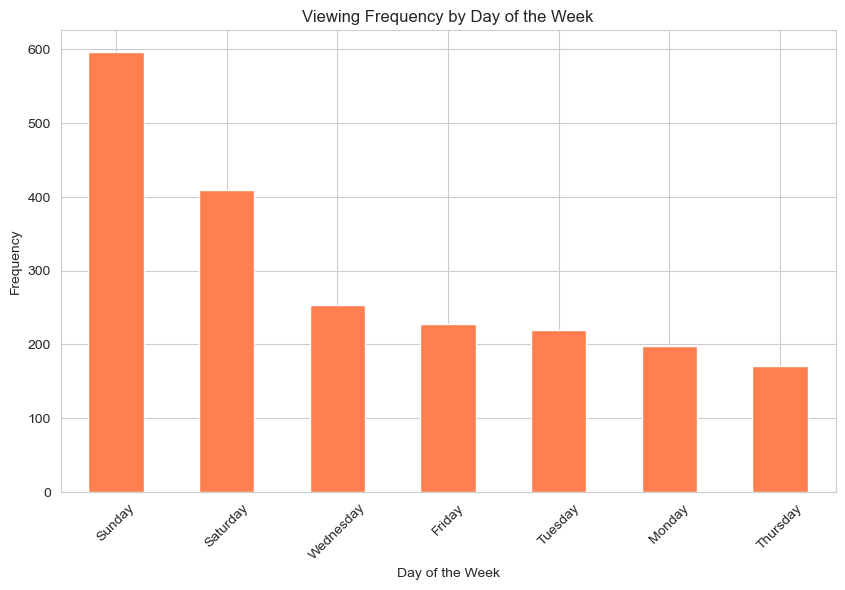

In [291]:
day_of_week_counts = netflix_data_cleaned['DayOfWeek'].value_counts()
plt.figure(figsize=(10, 6))
day_of_week_counts.plot(kind='bar', color='coral')
plt.title('Viewing Frequency by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

---
Viewing patterns by month


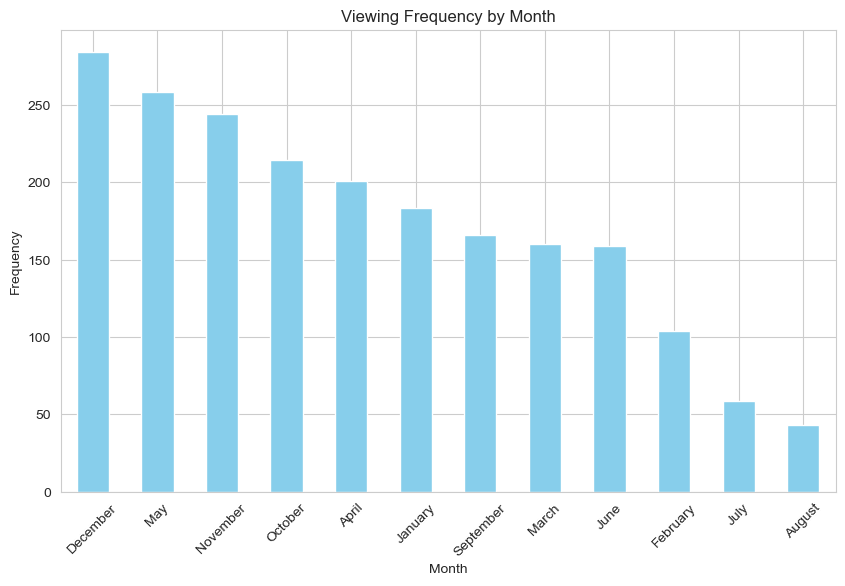

In [292]:
month_counts = netflix_data_cleaned['Month'].value_counts()
plt.figure(figsize=(10, 6))
month_counts.plot(kind='bar', color='skyblue')
plt.title('Viewing Frequency by Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

---
Binge Watching and Repeated watchings

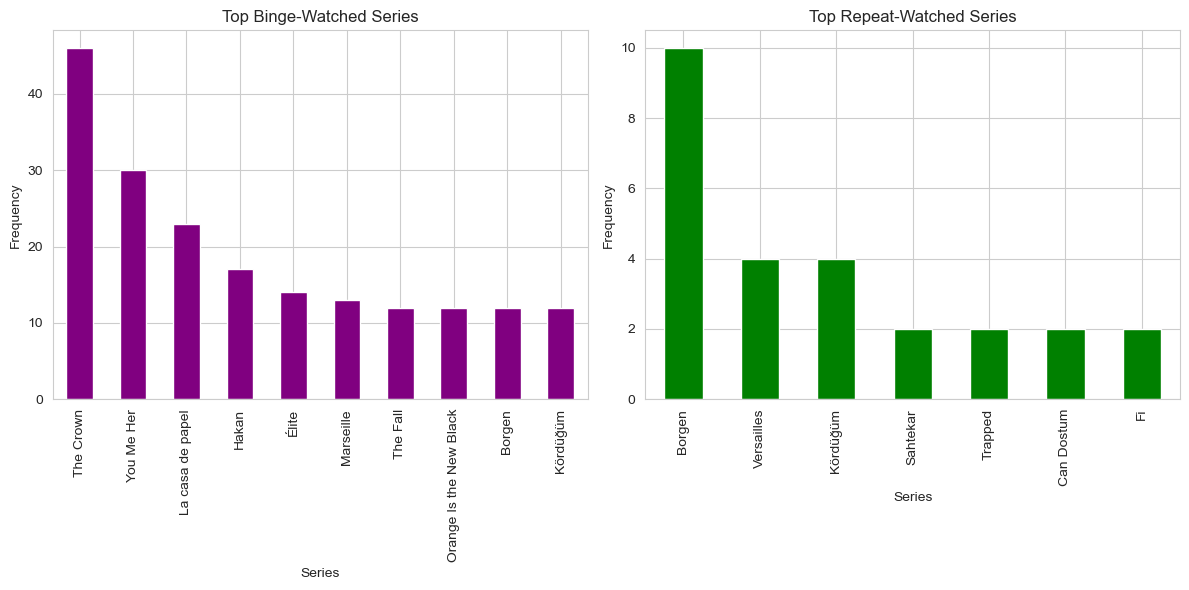

In [293]:
import numpy as np

# Binge-Watching Habits
binge_watching = netflix_data_cleaned[netflix_data_cleaned.duplicated(subset=['Date', 'Series'], keep=False)]
binge_watching_count = binge_watching['Series'].value_counts().head(10)

# Series or episodes watched more than once
repeat_watching = netflix_data_cleaned[netflix_data_cleaned.duplicated(subset=['Series', 'Episode'], keep=False)]
repeat_watching_count = repeat_watching['Series'].value_counts().head(10)

# Visualizing the Binge-Watching and Repeat Watching
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
binge_watching_count.plot(kind='bar', color='purple')
plt.title('Top Binge-Watched Series')
plt.xlabel('Series')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
repeat_watching_count.plot(kind='bar', color='green')
plt.title('Top Repeat-Watched Series')
plt.xlabel('Series')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

---
TREND OVER TIME
Monthly Trend & Weekly Trend 

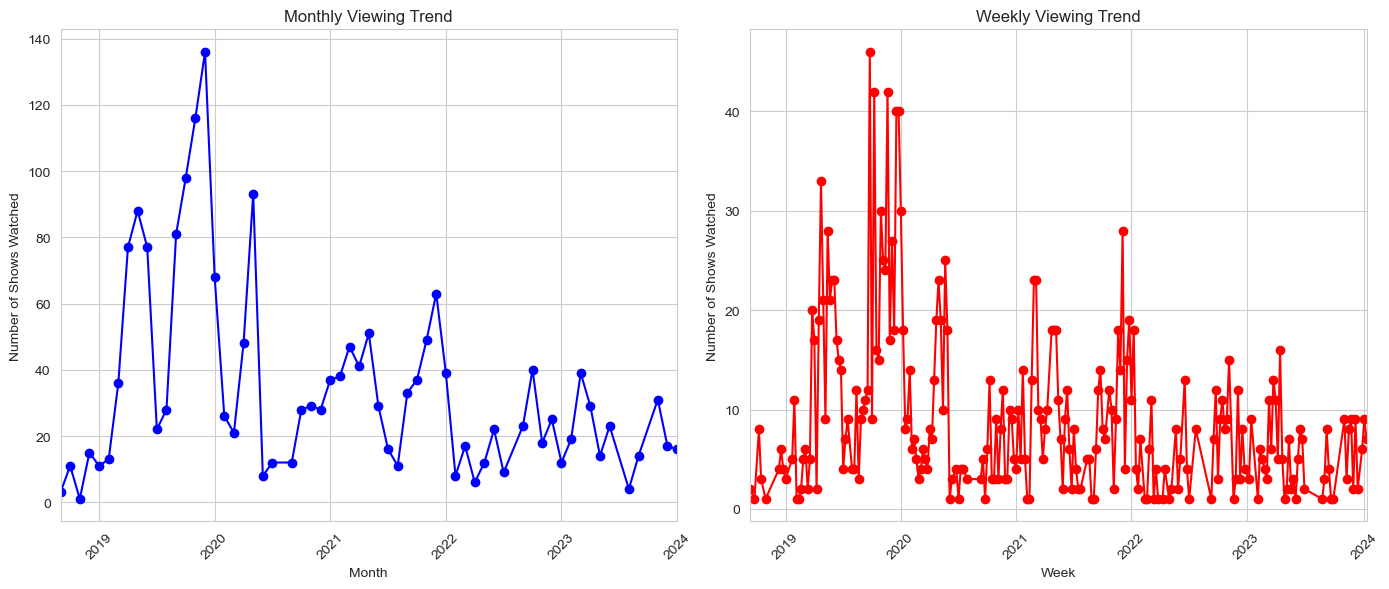

In [295]:
# Monthly Trend Analysis
monthly_trend = netflix_data_cleaned.groupby(netflix_data_cleaned['Date'].dt.to_period('M')).size()

# Weekly Trend Analysis
weekly_trend = netflix_data_cleaned.groupby(netflix_data_cleaned['Date'].dt.to_period('W')).size()

# Visualizing Monthly and Weekly Trends
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
monthly_trend.plot(kind='line', color='blue', marker='o')
plt.title('Monthly Viewing Trend')
plt.xlabel('Month')
plt.ylabel('Number of Shows Watched')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
weekly_trend.plot(kind='line', color='red', marker='o')
plt.title('Weekly Viewing Trend')
plt.xlabel('Week')
plt.ylabel('Number of Shows Watched')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


---
Monthly Distribution of top 7 Series Watched

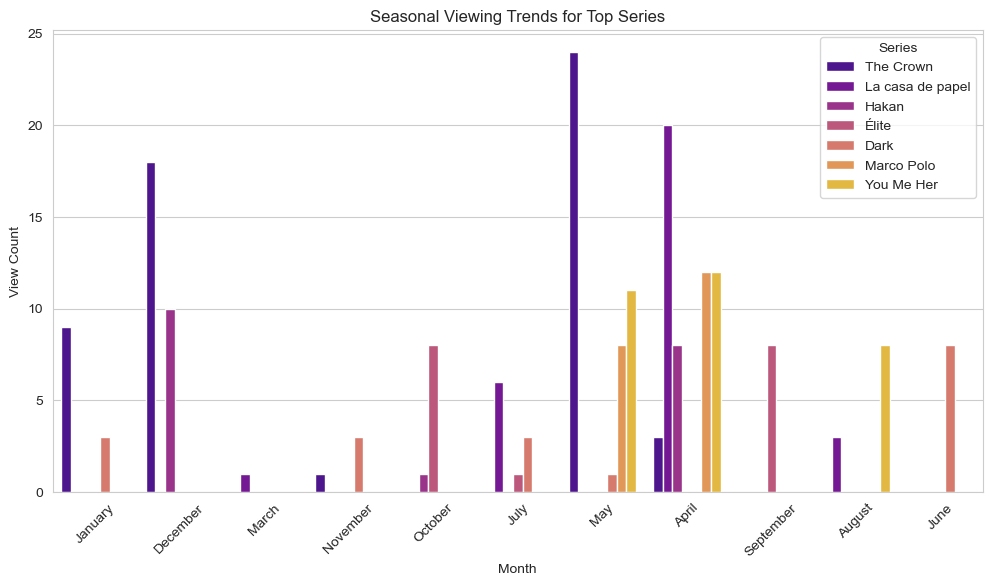

In [296]:
top_series = netflix_data_cleaned['Series'].value_counts().nlargest(7).index
filtered_data = netflix_data_cleaned[netflix_data_cleaned['Series'].isin(top_series)]

# a bar plot
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', hue='Series', data=filtered_data, palette='plasma')
plt.title('Seasonal Viewing Trends for Top Series')
plt.xlabel('Month')
plt.ylabel('View Count')
plt.xticks(rotation=45)
plt.legend(title='Series', loc='upper right')
# display episode counts in specific months
plt.show()


---
Correlation between number of Seasons of Series and Watching Frequency

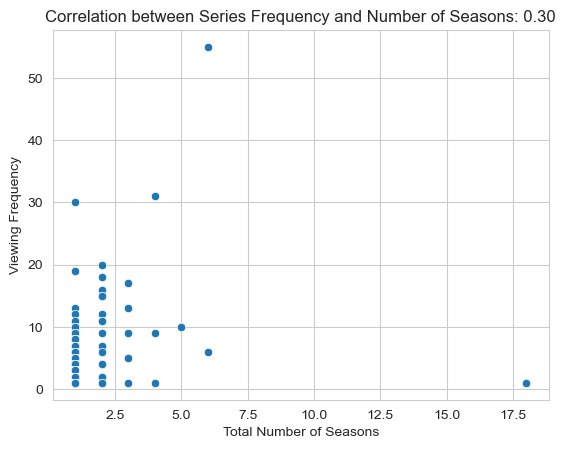

In [297]:
# season to numeric
netflix_data_cleaned['Season'] = pd.to_numeric(netflix_data_cleaned['Season'], errors='coerce')

total_seasons = netflix_data_cleaned.groupby('Series')['Season'].max().reset_index()
total_seasons.rename(columns={'Season': 'TotalSeasons'}, inplace=True)

netflix_data_with_seasons = pd.merge(netflix_data_cleaned, total_seasons, on='Series', how='left')

# 'TotalSeasons' is numeric
netflix_data_with_seasons['TotalSeasons'] = pd.to_numeric(netflix_data_with_seasons['TotalSeasons'], errors='coerce')

# frequency of each series
series_frequency = netflix_data_with_seasons['Series'].value_counts()


correlation_df = pd.DataFrame({
    'Series': series_frequency.index,
    'Frequency': series_frequency.values
})

correlation_df = correlation_df.merge(total_seasons, on='Series')

correlation = correlation_df['Frequency'].corr(correlation_df['TotalSeasons'])

# Plotting the correlation
sns.scatterplot(data=correlation_df, x='TotalSeasons', y='Frequency')
plt.title(f'Correlation between Series Frequency and Number of Seasons: {correlation:.2f}')
plt.xlabel('Total Number of Seasons')
plt.ylabel('Viewing Frequency')
plt.show()



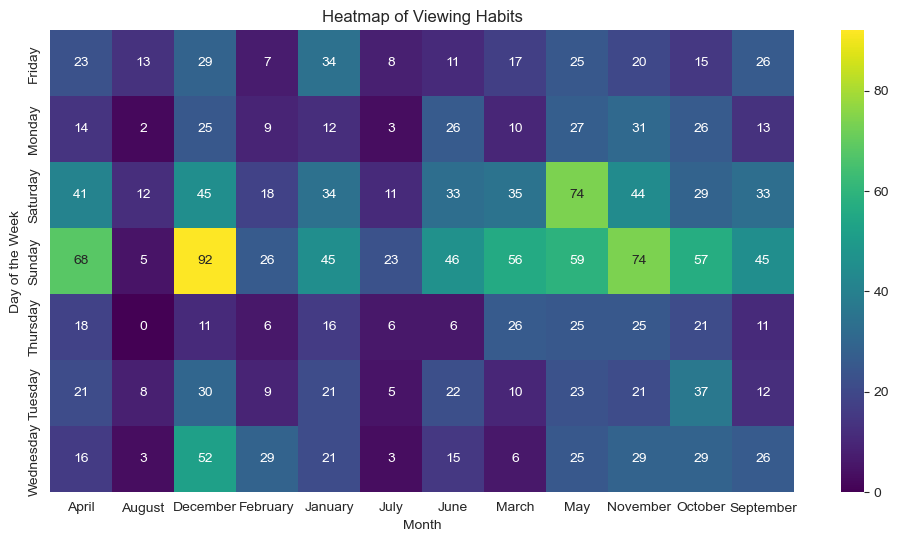

In [298]:
# Creating a pivot table for the heatmap
heatmap_data = netflix_data_cleaned.pivot_table(index='DayOfWeek', columns='Month', aggfunc='size', fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='viridis', annot=True)
plt.title('Heatmap of Viewing Habits')
plt.xlabel('Month')
plt.ylabel('Day of the Week')
plt.show()


---
Top 50 Series Timeline
---

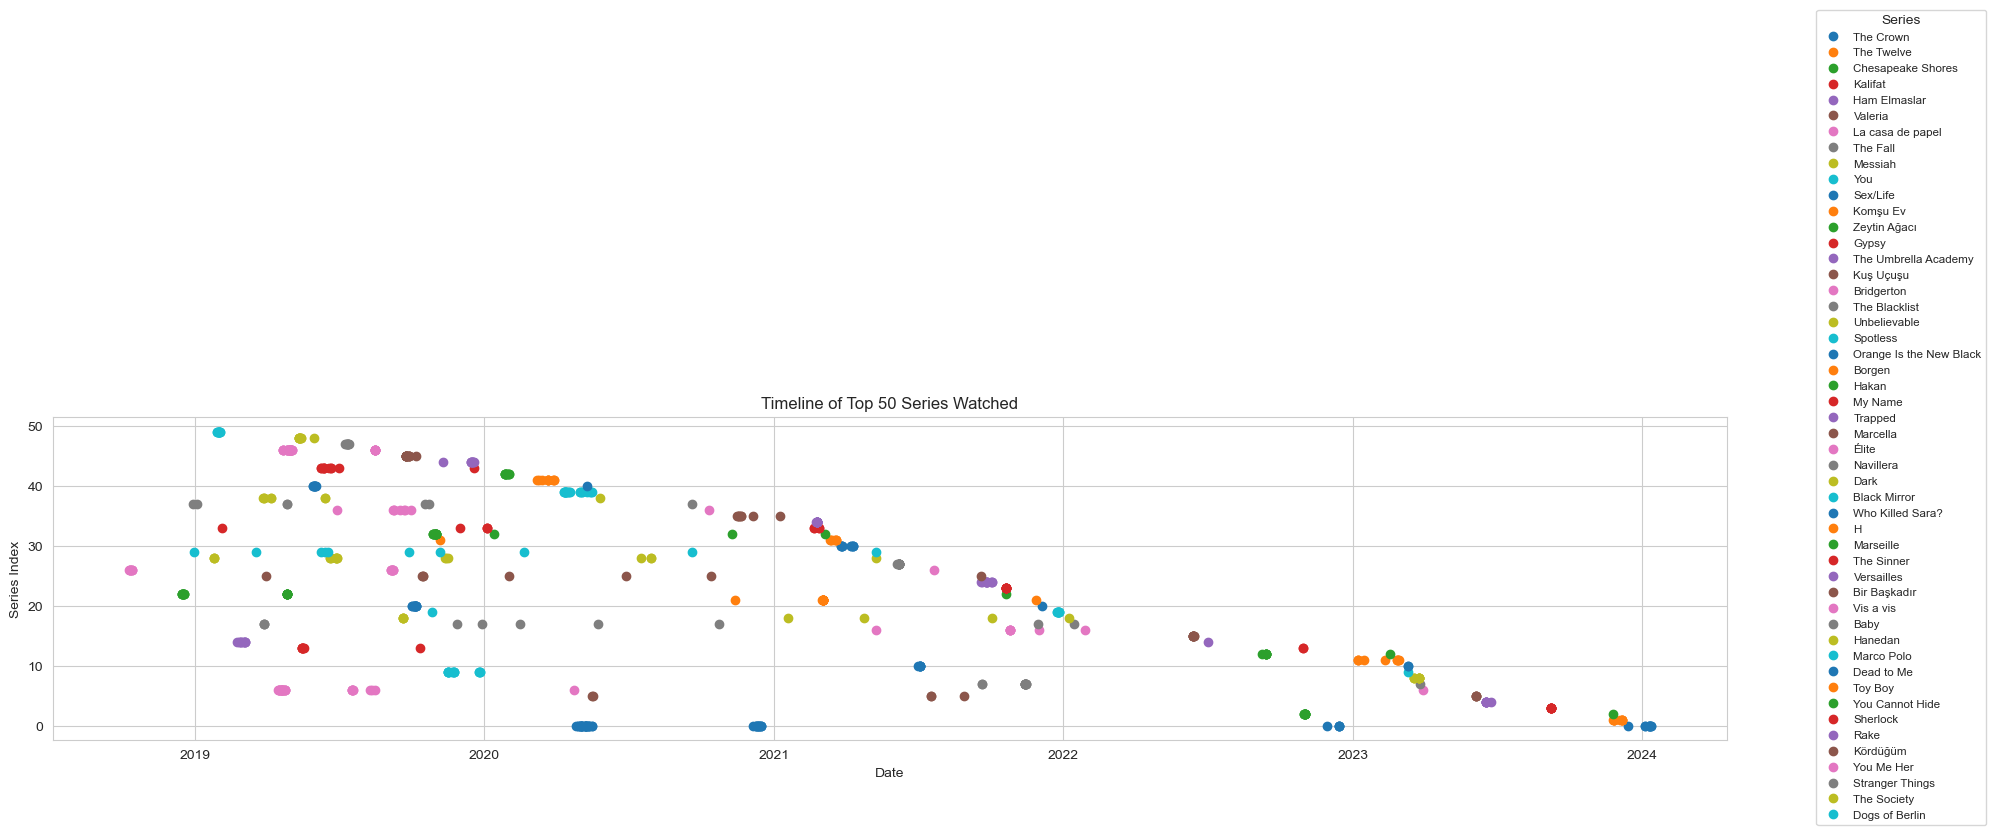

In [299]:
# top 50 series based on viewing frequency
top_50_series = netflix_data_cleaned['Series'].value_counts().head(50).index
filtered_data = netflix_data_cleaned[netflix_data_cleaned['Series'].isin(top_50_series)]

# assign a unique number to each series in the top 50
unique_series = filtered_data['Series'].unique()
series_mapping = {series: i for i, series in enumerate(unique_series)}

plt.figure(figsize=(20, 8))

for series in unique_series:
    series_data = filtered_data[filtered_data['Series'] == series]
    plt.plot(series_data['Date'], [series_mapping[series]] * len(series_data), 'o', label=series)

plt.xlabel('Date')
plt.ylabel('Series Index')
plt.title('Timeline of Top 50 Series Watched')

# legend
plt.legend(title='Series', bbox_to_anchor=(1.05, 1), loc='center left', ncol=1, fontsize='small', fancybox=True)
plt.tight_layout()  
plt.show()


Machine Learning Model for 
---


In [300]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Step 1: Encode Day of the Week and Month
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(netflix_data_cleaned[['DayOfWeek', 'Month']])

# Step 2: Aggregate Data
# Convert the encoded features back to a DataFrame
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(['DayOfWeek', 'Month']))

# Step 3: Apply K-means Clustering
kmeans = KMeans(n_clusters=12, random_state=0)  
cluster_labels = kmeans.fit_predict(encoded_df)

netflix_data_cleaned['Cluster'] = cluster_labels

# Step 4: Analyze Clusters
cluster_analysis = netflix_data_cleaned.groupby('Cluster')['DayOfWeek', 'Month'].agg(pd.Series.mode)

cluster_analysis

/var/folders/ck/hl0bm7bx7pjb6v65rqz4__sc0000gn/T/ipykernel_57838/3281684353.py:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_analysis = netflix_data_cleaned.groupby('Cluster')['DayOfWeek', 'Month'].agg(pd.Series.mode)


,DayOfWeek,Month
Cluster,,
0,Sunday,April
1,Saturday,December
2,Friday,January
3,Tuesday,October
4,Wednesday,December
5,Monday,November
6,Thursday,March
7,Saturday,May
8,Sunday,March


---
Predicting Interest levels for Series


In [301]:

netflix_data_cleaned = netflix_data_cleaned.sort_values(['Series', 'Date'])

netflix_data_cleaned['Interest_Level'] = 'Low'  # Default to 'Low'

def assign_interest_level(group):
    group = group.reset_index(drop=True)
    consecutive_count = 1  # Counter for consecutive episodes

    for i in range(1, len(group)):
        # Check if the current episode is watched on the same day as the previous one
        if group.loc[i, 'Date'] == group.loc[i-1, 'Date']:
            consecutive_count += 1
        else:
            consecutive_count = 1  # Reset counter if not consecutive

        # Assign interest level based on consecutive count
        if consecutive_count >= 6:
            group.loc[i, 'Interest_Level'] = 'High'
        elif consecutive_count >= 3:
            group.loc[i, 'Interest_Level'] = 'Mid'

    return group

netflix_data_cleaned = netflix_data_cleaned.groupby('Series').apply(assign_interest_level)

netflix_data_cleaned = netflix_data_cleaned.reset_index(drop=True)



In [306]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder


# Step 1: Convert 'Date' to numerical features (Year, Month, Day)
netflix_data_cleaned['Year'] = netflix_data_cleaned['Date'].dt.year
netflix_data_cleaned['Month_Num'] = netflix_data_cleaned['Date'].dt.month
netflix_data_cleaned['Day'] = netflix_data_cleaned['Date'].dt.day
netflix_data_cleaned.drop(['Date'], axis=1, inplace=True)

# Convert 'Interest_Level' to numeric
interest_mapping = {'Low': 0, 'Mid': 1, 'High': 2}
netflix_data_cleaned['Numeric_Interest'] = netflix_data_cleaned['Interest_Level'].map(interest_mapping)

# One-hot encode categorical variables
one_hot_encoded_data = pd.get_dummies(netflix_data_cleaned.drop(['Interest_Level', 'Numeric_Interest'], axis=1))

# Prepare the data for the model
X = one_hot_encoded_data
y = netflix_data_cleaned['Numeric_Interest']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

# Random Forest Regressor Model
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

# Evaluate the models
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Linear Regression - MSE: {mse_lin}, R²: {r2_lin}")
print(f"Random Forest Regressor - MSE: {mse_rf}, R²: {r2_rf}")


Linear Regression - MSE: 0.12022586728679313, R²: 0.12833194799123526
Random Forest Regressor - MSE: 0.11662512077294689, R²: 0.15443827411167488


In [307]:
# To see if interest levels are correctly implemented
sorted_data = netflix_data_cleaned.sort_values(by='Numeric_Interest', ascending=False)
sorted_data


,Title,Series,Season,Episode,DayOfWeek,Month,Cluster,Interest_Level,Year,Month_Num,Day,Numeric_Interest
1093,Navillera: 1. Sezon: 3. Bölüm,Navillera,1,3. Bölüm,Monday,June,5,High,2021,6,7,2
636,Ham Elmaslar: 1. Sezon: 1. Bölüm,Ham Elmaslar,1,1. Bölüm,Sunday,June,0,High,2023,6,18,2
1069,My Name: 1. Sezon: 2. Bölüm,My Name,1,2. Bölüm,Wednesday,October,4,High,2021,10,20,2
1068,My Name: 1. Sezon: 3. Bölüm,My Name,1,3. Bölüm,Wednesday,October,4,High,2021,10,20,2
1821,Versailles: 1. Sezon: 2. Bölüm,Versailles,1,2. Bölüm,Wednesday,February,4,High,2021,2,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
706,II. Dünya Savaşı'nın En Önemli Olayları (Renkl...,II. Dünya Savaşı'nın En Önemli Olayları (Renkli),1,Blitzkrieg,Saturday,November,1,Low,2019,11,16,0
705,I Care a Lot,I Care a Lot,1,Movie/Mini Series,Sunday,January,0,Low,2024,1,7,0
704,Hırsızlar Şehri,Hırsızlar Şehri,1,Movie/Mini Series,Sunday,January,0,Low,2020,1,12,0
703,Hırs,Hırs,1,Movie/Mini Series,Sunday,March,8,Low,2023,3,12,0


In [308]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Convert 'Interest_Level' into a binary target variable
# 'High' and 'Mid' are 1 (High Engagement), 'Low' is 0 (Low Engagement)
netflix_data_cleaned['Engagement'] = netflix_data_cleaned['Interest_Level'].apply(lambda x: 1 if x in ['High', 'Mid'] else 0)

# One-hot encode categorical variables
X = pd.get_dummies(netflix_data_cleaned.drop(['Interest_Level', 'Numeric_Interest', 'Engagement'], axis=1))
y = netflix_data_cleaned['Engagement']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_test)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the models
accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Decision Tree Accuracy: {accuracy_dt}")
print(f"Random Forest Accuracy: {accuracy_rf}")
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))


Decision Tree Accuracy: 0.8872785829307569
Random Forest Accuracy: 0.9033816425120773

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       560
           1       0.55      0.10      0.17        61

    accuracy                           0.90       621
   macro avg       0.73      0.54      0.56       621
weighted avg       0.87      0.90      0.87       621

